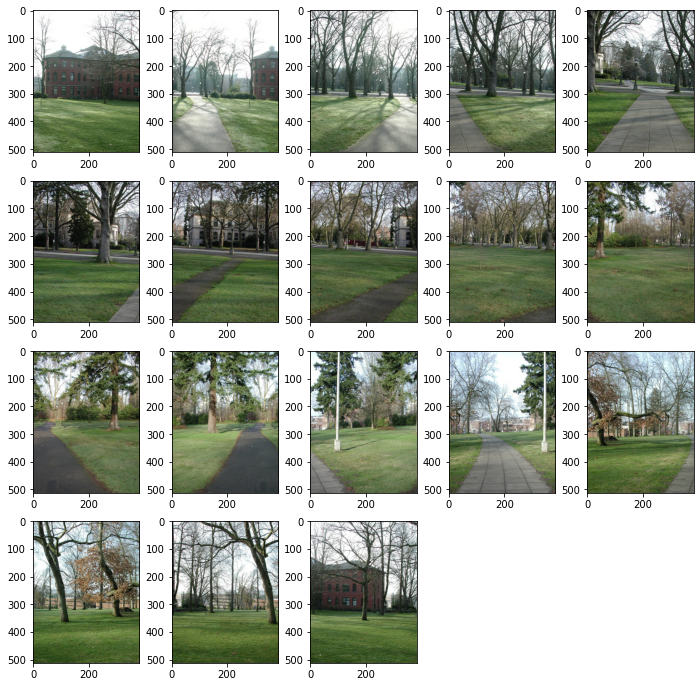

In [8]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

focal_len = 705
path = "./data/parrington/prtn*.jpg"
files = glob.glob(path)
files.sort(reverse=False)
images = [cv2.imread(f) for f in files]

plt.figure(figsize=(12,12))
for i in range(len(images)):
    plt.subplot(4, math.ceil(len(images)/4), i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

In [9]:
def warp(image):
    result_width = round(math.atan(image.shape[1]/2/focal_len) * focal_len * 2)
    result_height = image.shape[0]
    origin_center_x = (image.shape[1]-1) / 2
    origin_center_y = (image.shape[0]-1) / 2

    result_center_x = (result_width-1) / 2
    result_center_y = (result_height-1) / 2

    # print(image.shape[1], image.shape[0])

    # print(result_width, result_height)

    def project_pixel(i, j):
        theta = (i - result_center_x)/focal_len
        h = j - result_center_y

        #print(i)
        # print(origin_center_x)
        x = round(focal_len * math.tan(theta) + origin_center_x)
        y = round(h / math.cos(theta) + origin_center_y)

        if x < 0 or y < 0 or x >= image.shape[1] or y >= image.shape[0]:
            return np.zeros(3)
        else:
            return image[y][x]

    result_image_idx = np.ndindex((result_height, result_width))
    result_image = np.array([project_pixel(j, i) for i, j in result_image_idx])
    return result_image.astype(np.uint8).reshape(result_height, result_width, 3)
    #return np.fromfunction(lambda i, j: project_pixel(i, j), (result_width, result_height), dtype=int)

In [10]:
# s = focal_len
# def warp_image(image):
#     result_image = np.zeros((image.shape[0], image.shape[1], 3))
#     center_y = image.shape[0] // 2
#     center_x = image.shape[1] // 2
#     def project_pixel(y, x):
#         now_y, now_x = y-center_y, x-center_x
#         h = now_y / math.sqrt(now_x**2 + focal_len**2) * s
#         theta = math.atan(now_y/focal_len) * s
#         result_image[round(center_y+h)][round(center_x+now_x)] = image[y][x]
    
#     result_image_idx = np.ndindex((image.shape[0], image.shape[1]))
#     [project_pixel(i,j) for i,j in result_image_idx]
#     return result_image.astype(np.uint8)
# img_warp = warp_image(images[0])
# plt.imshow(img_warp)

<Figure size 432x288 with 0 Axes>

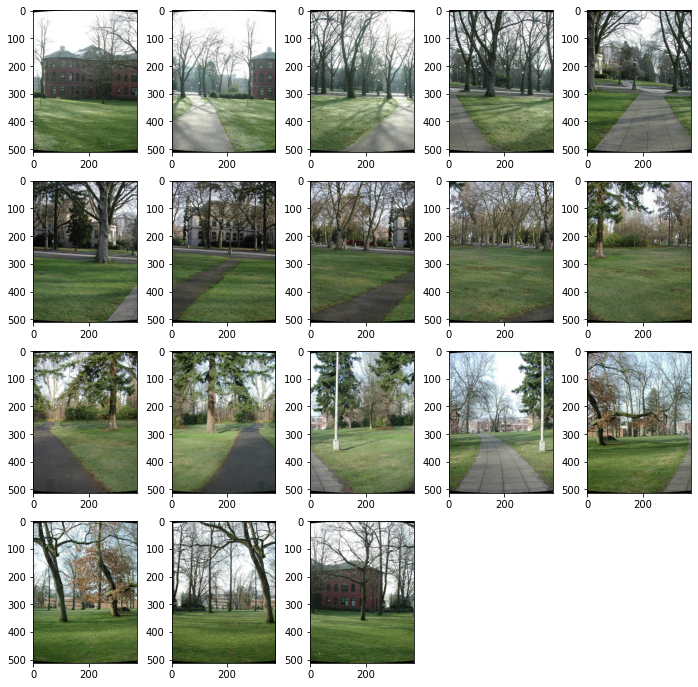

In [11]:
result_images = [warp(img) for img in images]

plt.clf()
plt.figure(figsize=(12,12))
for i in range(len(result_images)):
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    plt.imshow(cv2.cvtColor(result_images[i], cv2.COLOR_BGR2RGB))

## Detection

In [14]:
def harris(gray_img, ksize, gksize, k):
    gray_img = np.float64(gray_img)
    dx = cv2.Scharr(gray_img, cv2.CV_64F, 1, 0, ksize)
    dy = cv2.Scharr(gray_img, cv2.CV_64F, 0, 1, ksize)
    
    Ixx = cv2.multiply(dx, dx)
    Iyy = cv2.multiply(dy, dy)
    Ixy = cv2.multiply(dx, dy)
    
    Sxx = cv2.GaussianBlur(Ixx, (gksize, gksize), 0)
    Syy = cv2.GaussianBlur(Iyy, (gksize, gksize), 0)
    Sxy = cv2.GaussianBlur(Ixy, (gksize, gksize), 0)

    det = Sxx * Syy - Sxy * Sxy
    trace = Sxx + Syy
    R = det - k * cv2.multiply(trace, trace)

    orientation = np.arctan2(dy, dx)
    
    return R, orientation

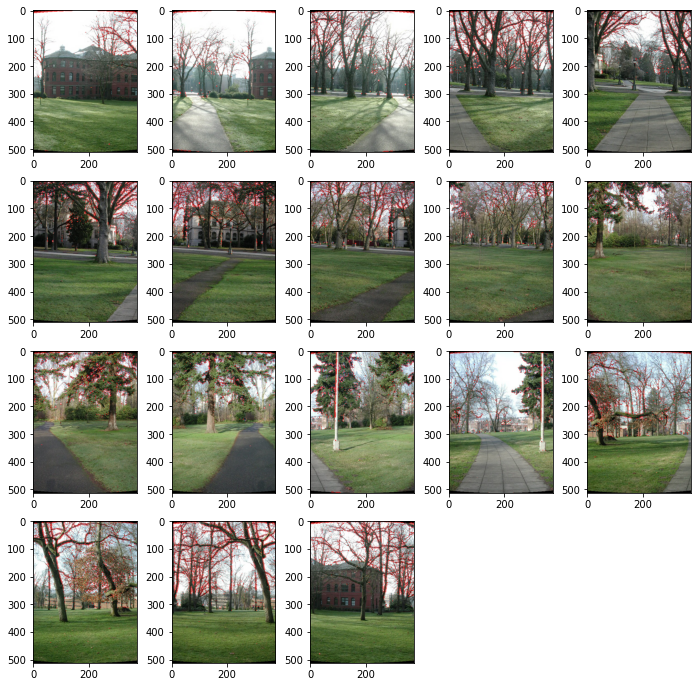

In [28]:
ksize = 3
gksize = 3
k = 0.05
threshold = 1
gray_images = []
harris_images = []
key_points_all = []
orientations = []

plt.figure(figsize=(12,12))
for i, img in enumerate(result_images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_img)
    
    harris_img, orientation = harris(gray_img, ksize, gksize, k)
    orientations.append(orientation)
    
    # dilate_img = cv2.dilate(harris_img, np.array([[0., -1., 0.], [-1., 4., -1.], [0., -1., 0.]]))
    dilate_img = cv2.Laplacian(harris_img, cv2.CV_64F, ksize = 3) * -1.0
    # dilate_img = harris_img
    labeled_img = img.copy()
    labeled_img[ dilate_img>0.02*dilate_img.max() ] = [0, 0, 255]
    key_points = np.where(dilate_img>0.02*dilate_img.max())
    key_points = np.flip(key_points, 0).T
    key_points_all.append(key_points)
    # cv2.threshold(dilate_img, dilate_img.max()*0.2, 255, cv2.THRESH_BINARY, dilate_img)
    
    
    
    harris_images.append(harris_img) 
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    #plt.imshow(dilate_img, cmap="gray")
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    
 

In [30]:
from scipy import interpolate
import numpy.matlib as matlib

def SIFT_descriptor(image, keypoints, orientations):
    # The orientation histograms have 8 bins
    pi = math.pi
    orient_bin_spacing = pi / 4
    orient_angles = np.arange(-pi, pi, orient_bin_spacing)

    # The feature grid is has 4x4 cells - feat_grid describes the cell center positions
    grid_spacing = 4
    ## Calc center coordinates of grids 
    center_coords = np.arange(-6, 7, grid_spacing)
    x_coords, y_coords = np.meshgrid(center_coords, center_coords)
    feat_grid = np.reshape(np.stack((x_coords, y_coords), axis = 2), (-1, 2))

    ## Calc center coordinates of pixels in 16*16 window
    center_coords = np.arange(-(2 * grid_spacing - 0.5), 2 * grid_spacing, 1)
    x_coords, y_coords = np.meshgrid(center_coords, center_coords)
    feat_samples = np.reshape(np.stack((x_coords, y_coords), axis = 2), (-1, 2))

    feat_window = 2 * grid_spacing

    descriptors = []

    for keypoint in keypoints:
        ## TODO
        x, y = keypoint
        orientation = orientations[y][x]

        M = np.array([
            [math.cos(orientation), -math.sin(orientation)], 
            [math.sin(orientation), math.cos(orientation)]
        ])

        feat_rot_grid = np.matmul(M, feat_grid.T).T + np.array(keypoint)
        feat_rot_samples = np.matmul(M, feat_samples.T).T + np.array(keypoint)

        feat_desc = np.zeros((1, 128))

        image_f = interpolate.interp2d(
            np.arange(image.shape[1]), 
            np.arange(image.shape[0]),
            image
        )

        for s in feat_rot_samples:
            x_sample = s[0]
            y_sample = s[1]

            G = image_f(
                np.arange(x_sample - 1, x_sample + 2), 
                np.arange(y_sample - 1, y_sample + 2)
            )

            diff_x = (G[1][2] - G[1][0]) / 2
            diff_y = (G[2][1] - G[0][1]) / 2

            mag_sample = np.linalg.norm([diff_x, diff_y])
            grad_sample = math.atan2(diff_y, diff_x)

            if grad_sample == pi:
                grad_sample = -pi

            x_wght = (1 - (abs(feat_rot_grid[:, 0].T - x_sample) / grid_spacing)).clip(min = 0)
            y_wght = (1 - (abs(feat_rot_grid[:, 1].T - y_sample) / grid_spacing)).clip(min = 0)
            pos_wght = np.reshape(matlib.repmat(x_wght*y_wght, 8, 1), (1, 128))
            
            diff = np.mod(grad_sample - orientation - orient_angles + pi, 2 * pi) - pi
            orient_wght = matlib.repmat((1 - abs(diff)/orient_bin_spacing).clip(min = 0), 1, 16)
            
            ## Compute the gaussian weighting.
            g = np.exp(-((x_sample-x)**2 + (y_sample-y)**2) / (2*feat_window**2)) / (2*pi*feat_window**2)

            ## Accumulate the histogram bins.
            feat_desc += pos_wght * orient_wght * g * mag_sample

        if np.linalg.norm(feat_desc) != 0:
            feat_desc = feat_desc / np.linalg.norm(feat_desc)

            feat_desc.clip(max = 0.2)
            feat_desc = feat_desc / np.linalg.norm(feat_desc)

        descriptors.append(feat_desc)
    
    return descriptors


In [31]:
descriptors = SIFT_descriptor(gray_images[0], key_points_all[0][:100], orientations[0])

In [33]:
print(descriptors[0].shape)

(1, 128)
